In [3]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
def preprocess(data):
    if 'label' in data.columns:
        temp = data[['Date', 'Open', 'Close', 'label']].copy()
    else:
        temp = data[['Date', 'Open', 'Close']].copy()
    temp['Norm_return'] = temp['Close'] / temp.iloc[0]['Close']
    temp['Allocation'] = temp['Norm_return'] * 1
    temp['Position'] = temp['Allocation'] * 1000 #Assume portfolio size is 10K
    temp['Daily_return'] = temp['Position'].pct_change(1)
    return temp

#If tomorrow is increasing, buy today and sell tomorrow immediately
def strategy1(data):
    new_rows = list()
    for i, row in data.iterrows():
        if(row['Predicted Values'] == 1):
            new_rows.append(row['Daily Return'])
        else:
            new_rows.append(None)
    new_rows_np = np.array(new_rows, dtype=np.float)
    return new_rows, new_rows_np

#If tomorrow is increasing, buy today and keep stock until price decreases
def strategy2(data):
    buy = False
    new_rows = list()
    for i, row in data.iterrows():
        if(row['Predicted Values'] == 1 and buy == False):
            buy = True
            new_rows.append(None)
        elif(buy == True and row['Predicted Values'] == -1):
            buy = False
            new_rows.append(None)
        elif(buy == True):
            new_rows.append(row['Daily Return'])
        else:
            new_rows.append(None)
    new_rows_np = np.array(new_rows, dtype=np.float)
    return new_rows, new_rows_np

def trendStrategy(data):
    buy = False
    new_rows = list()
    for i, row in data.iterrows():
        if(row['FGS'] != 0 and buy == False):
            buy = True
            new_rows.append(None)
        elif(buy == True and row['FGS'] == 0):
            buy = False
            new_rows.append(None)
        elif(buy == True):
            new_rows.append(row['Daily_return'])
        else:
            new_rows.append(None)
    new_rows_np = np.array(new_rows, dtype=np.float)
    return new_rows, new_rows_np

#Run strategies above first to get np data
def getSharpeRatio(np_data):
    #Assume Risk free ratio is 0
    sharpeRatio = (np.nanmean(np_data) - 0)/np.nanstd(np_data)
    return sharpeRatio


In [4]:
nq = pd.read_csv('@NQ_Daily.txt', sep=',')

In [4]:
## 1st period: 01/10/2007 - 11/03/2008 -> Decreasing close price
# nq_1 = nq[1851:2314]
# nq_1 = preprocess(nq_1)
# nq_1_temp = nq[1856:2312]
# nq_1_temp.head()

In [48]:
## 2nd period: 03/04/2016 - 01/03/2018 -> Increasing close price
nq_2 = nq[4171:4623]
nq_2_temp = nq[4171:4624]
nq_2_new = nq[4170:4622]
nq_2_new = preprocess(nq_2_new)
nq_2 = preprocess(nq_2)
nq_2_temp = preprocess(nq_2_temp)
nq_2.tail()
nq_2_test = [nq_2_new, nq['FGS'][4170:4622]]
nq_2_test = pd.concat(nq_2_test, axis=1)

In [50]:
len(nq_2_test)

452

# Period 1
## Buy and Hold Sharpe Ratio

In [51]:
buyandholdRows = list()
for i, row in nq_2.iterrows():
        buyandholdRows.append(row['Daily_return'])

In [52]:
buyandholdRows_np = np.array(buyandholdRows, dtype=np.float)
buyandhold_sharpe = np.nanmean(buyandholdRows_np)/np.nanstd(buyandholdRows_np)
buyandhold_sharpe

0.12168870111674589

## Trend Strategy Sharpe Ratio

In [53]:
trendRows, trendRows_np = trendStrategy(nq_2_test)


print("Sharpe Ratio for Trend Strategy is : ", getSharpeRatio(trendRows_np))

Sharpe Ratio for Trend Strategy is :  0.09376053405584385


## Bi-Directional LSTM Sharpe Ratio
### Preparation

In [54]:
lstm_prediction = pd.read_csv('data/bi_lstm_second_half.csv')
lstm_prediction = lstm_prediction[:-4]
lstm_prediction.tail()

,Date,True Closing Values,Predicted Closing Values,True Values,Predicted Values
447,12/19/2017,6500.75,6540.357852,Down,No Change
448,12/20/2017,6489.00,6530.224840,No Change,Up
449,12/21/2017,6492.25,6509.838271,No Change,No Change
450,12/22/2017,6483.75,6490.701045,No Change,No Change
451,12/26/2017,6460.00,6465.707148,No Change,No Change


In [55]:
##Change to 1, 0, -1 (Up, Down, No change)
lstm_prediction['True Values'] = lstm_prediction['True Values'].map({'No Change': 0, 'Down': -1, 'Up': 1})
lstm_prediction['Predicted Values'] = lstm_prediction['Predicted Values'].map({'No Change': 0, 'Down': -1, 'Up': 1})

In [56]:
lstm_prediction = lstm_prediction.set_index(nq_2.index)
lstm_prediction['Date'] = nq_2.iloc[:,0].values
lstm_prediction.head()

,Date,True Closing Values,Predicted Closing Values,True Values,Predicted Values
4171,03/14/2016,4381.50,4374.948820,NaN,NaN
4172,03/15/2016,4380.00,4374.566875,0.0,0.0
4173,03/16/2016,4412.00,4357.843038,1.0,-1.0
4174,03/17/2016,4416.75,4370.112240,0.0,-1.0
4175,03/18/2016,4418.50,4439.349702,0.0,1.0


In [57]:
lstm_prediction["Daily Return"] = nq_2['Daily_return']
lstm_prediction.head()

,Date,True Closing Values,Predicted Closing Values,True Values,Predicted Values,Daily Return
4171,03/14/2016,4381.50,4374.948820,NaN,NaN,NaN
4172,03/15/2016,4380.00,4374.566875,0.0,0.0,-0.000342
4173,03/16/2016,4412.00,4357.843038,1.0,-1.0,0.007306
4174,03/17/2016,4416.75,4370.112240,0.0,-1.0,0.001077
4175,03/18/2016,4418.50,4439.349702,0.0,1.0,0.000396


### Strategy 1

In [58]:
lstm_rows_1, lstm_np_1 = strategy1(lstm_prediction)

In [59]:
print("Sharpe Ratio for Bi-Directional LSTM using strategy 1 is: ", getSharpeRatio(lstm_np_1))

Sharpe Ratio for Bi-Directional LSTM using strategy 1 is:  0.23209211072945726


### Strategy 2

In [60]:
lstm_rows_2, lstm_np_2 = strategy2(lstm_prediction)

In [61]:
print("Sharpe Ratio for Bi-Directional LSTM using strategy 2 is: ", getSharpeRatio(lstm_np_2))

Sharpe Ratio for Bi-Directional LSTM using strategy 2 is:  0.0947375527705677


## CNN Sharpe Ratio

In [62]:
cnn_prediction = pd.read_csv('data/cnn_second_half.csv')
cnn_prediction = cnn_prediction[4:]
cnn_prediction.tail()

,Date,True Closing Values,Predicted Closing Values,True Values,Predicted Values
451,12/19/2017,6500.75,6539.931032,Down,No Change
452,12/20/2017,6489.00,6476.720416,No Change,No Change
453,12/21/2017,6492.25,6510.229017,No Change,No Change
454,12/22/2017,6483.75,6533.899004,No Change,Up
455,12/26/2017,6460.00,6477.536562,No Change,No Change


In [63]:
##Change to 1, 0, -1 (Up, Down, No change)
cnn_prediction['True Values'] = cnn_prediction['True Values'].map({'No Change': 0, 'Down': -1, 'Up': 1})
cnn_prediction['Predicted Values'] = cnn_prediction['Predicted Values'].map({'No Change': 0, 'Down': -1, 'Up': 1})

In [64]:
nq_2 = preprocess(nq_2)
cnn_prediction = cnn_prediction.set_index(nq_2.index)
cnn_prediction['Date'] = nq_2.iloc[:,0].values
cnn_prediction.head()

,Date,True Closing Values,Predicted Closing Values,True Values,Predicted Values
4171,03/14/2016,4381.50,4409.130434,0,1
4172,03/15/2016,4380.00,4377.969669,0,0
4173,03/16/2016,4412.00,4312.249146,1,-1
4174,03/17/2016,4416.75,4438.102763,0,1
4175,03/18/2016,4418.50,4419.954985,0,0


In [65]:
cnn_prediction["Daily Return"] = nq_2['Daily_return']
cnn_prediction.head()

,Date,True Closing Values,Predicted Closing Values,True Values,Predicted Values,Daily Return
4171,03/14/2016,4381.50,4409.130434,0,1,NaN
4172,03/15/2016,4380.00,4377.969669,0,0,-0.000342
4173,03/16/2016,4412.00,4312.249146,1,-1,0.007306
4174,03/17/2016,4416.75,4438.102763,0,1,0.001077
4175,03/18/2016,4418.50,4419.954985,0,0,0.000396


### Strategy 1

In [66]:
cnn_rows_1, cnn_np_1 = strategy1(cnn_prediction)
print("Sharpe Ratio for cnn using strategy 1 is: ", getSharpeRatio(cnn_np_1))

Sharpe Ratio for cnn using strategy 1 is:  0.23266012961934252


### Strategy 2

In [67]:
cnn_rows_2, cnn_np_2 = strategy2(cnn_prediction)
print("Sharpe Ratio for cnn using strategy 2 is: ", getSharpeRatio(cnn_np_2))

Sharpe Ratio for cnn using strategy 2 is:  0.2920369059726796


## CSC Sharpe Ratio

In [68]:
csc_prediction = pd.read_csv('data/csc_second_half.csv')
csc_prediction = csc_prediction[4:-5]
csc_prediction.tail()

,Date,True Closing Values,Predicted Closing Values,True Values,Predicted Values
451,12/19/2017,6500.75,6525.342950,Down,No Change
452,12/20/2017,6489.00,6510.383158,No Change,No Change
453,12/21/2017,6492.25,6513.510273,No Change,Up
454,12/22/2017,6483.75,6512.197309,No Change,Up
455,12/26/2017,6460.00,6506.319395,Down,Up


In [69]:
##Change to 1, 0, -1 (Up, Down, No change)
csc_prediction['True Values'] = csc_prediction['True Values'].map({'No Change': 0, 'Down': -1, 'Up': 1})
csc_prediction['Predicted Values'] = csc_prediction['Predicted Values'].map({'No Change': 0, 'Down': -1, 'Up': 1})

In [70]:
nq_2 = preprocess(nq_2)
csc_prediction = csc_prediction.set_index(nq_2.index)
csc_prediction['Date'] = nq_2.iloc[:,0].values
csc_prediction.head()

,Date,True Closing Values,Predicted Closing Values,True Values,Predicted Values
4171,03/14/2016,4381.50,4354.403221,1,-1
4172,03/15/2016,4380.00,4379.216489,0,0
4173,03/16/2016,4412.00,4384.749710,1,0
4174,03/17/2016,4416.75,4413.985817,0,0
4175,03/18/2016,4418.50,4422.832827,0,0


In [71]:
csc_prediction["Daily Return"] = nq_2['Daily_return']
csc_prediction.head()

,Date,True Closing Values,Predicted Closing Values,True Values,Predicted Values,Daily Return
4171,03/14/2016,4381.50,4354.403221,1,-1,NaN
4172,03/15/2016,4380.00,4379.216489,0,0,-0.000342
4173,03/16/2016,4412.00,4384.749710,1,0,0.007306
4174,03/17/2016,4416.75,4413.985817,0,0,0.001077
4175,03/18/2016,4418.50,4422.832827,0,0,0.000396


### Strategy 1

In [72]:
csc_rows_1, csc_np_1 = strategy1(csc_prediction)
print("Sharpe Ratio for csc using strategy 1 is: ", getSharpeRatio(csc_np_1))

Sharpe Ratio for csc using strategy 1 is:  0.4892123149318724


### Strategy 2

In [73]:
csc_rows_2, csc_np_2 = strategy2(csc_prediction)
print("Sharpe Ratio for csc using strategy 2 is: ", getSharpeRatio(csc_np_2))

Sharpe Ratio for csc using strategy 2 is:  0.1831927802144866


## Bi-Directional LSTM Autoencoders Sharpe Ratio

In [74]:
biauto_prediction = pd.read_csv('data/bi_lstm_autoencoders_second_half.csv')
biauto_prediction = biauto_prediction[:-5]
biauto_prediction.tail()

,Date,True Closing Values,Predicted Closing Values,True Values,Predicted Values
447,12/19/2017,6500.75,6482.718013,Down,Down
448,12/20/2017,6489.00,6515.480154,No Change,No Change
449,12/21/2017,6492.25,6539.649639,No Change,Up
450,12/22/2017,6483.75,6565.505064,No Change,Up
451,12/26/2017,6460.00,6561.306950,Down,Up


In [75]:
##Change to 1, 0, -1 (Up, Down, No change)
biauto_prediction['True Values'] = biauto_prediction['True Values'].map({'No Change': 0, 'Down': -1, 'Up': 1})
biauto_prediction['Predicted Values'] = biauto_prediction['Predicted Values'].map({'No Change': 0, 'Down': -1, 'Up': 1})

In [76]:
nq_2 = preprocess(nq_2)
biauto_prediction = biauto_prediction.set_index(nq_2.index)
biauto_prediction['Date'] = nq_2.iloc[:,0].values
biauto_prediction.head()

,Date,True Closing Values,Predicted Closing Values,True Values,Predicted Values
4171,03/14/2016,4381.50,4436.660814,NaN,NaN
4172,03/15/2016,4380.00,4463.998293,0.0,1.0
4173,03/16/2016,4412.00,4449.133691,1.0,1.0
4174,03/17/2016,4416.75,4433.043533,0.0,1.0
4175,03/18/2016,4418.50,4406.623977,0.0,0.0


In [77]:
biauto_prediction["Daily Return"] = nq_2['Daily_return']
biauto_prediction.head()

,Date,True Closing Values,Predicted Closing Values,True Values,Predicted Values,Daily Return
4171,03/14/2016,4381.50,4436.660814,NaN,NaN,NaN
4172,03/15/2016,4380.00,4463.998293,0.0,1.0,-0.000342
4173,03/16/2016,4412.00,4449.133691,1.0,1.0,0.007306
4174,03/17/2016,4416.75,4433.043533,0.0,1.0,0.001077
4175,03/18/2016,4418.50,4406.623977,0.0,0.0,0.000396


### Strategy 1

In [78]:
biauto_rows_1, biauto_np_1 = strategy1(biauto_prediction)
print("Sharpe Ratio for bi-lstm autoencoders using strategy 1 is: ", getSharpeRatio(biauto_np_1))

Sharpe Ratio for bi-lstm autoencoders using strategy 1 is:  0.18973843656718634


### Strategy 2

In [79]:
biauto_rows_2, biauto_np_2 = strategy2(biauto_prediction)
print("Sharpe Ratio for bi-lstm autoencoders using strategy 2 is: ", getSharpeRatio(biauto_np_2))

Sharpe Ratio for bi-lstm autoencoders using strategy 2 is:  0.17701182808717222


## WaveNet Sharpe Ratio

In [80]:
wavenet_prediction = pd.read_csv('data/wavenet_second_half.csv')
wavenet_prediction = wavenet_prediction.rename(index=str, columns={"Next_Day_Prediction": "Predicted Values", "Next_Day_Original": "True Values"})
wavenet_prediction = wavenet_prediction[1:-2]
wavenet_prediction.tail()

,Date,Predicted Values,True Values
448,2017-12-19,No Change,No Change
449,2017-12-20,No Change,No Change
450,2017-12-21,Up,No Change
451,2017-12-22,No Change,Down
452,2017-12-26,Up,No Change


In [81]:
##Change to 1, 0, -1 (Up, Down, No change)
wavenet_prediction['True Values'] = wavenet_prediction['True Values'].map({"No Change": 0, 'Down': -1, 'Up': 1})
wavenet_prediction['Predicted Values'] = wavenet_prediction['Predicted Values'].map({'No Change': 0, 'Down': -1, 'Up': 1})

In [82]:
wavenet_prediction = wavenet_prediction.set_index(nq_2.index)
wavenet_prediction['Date'] = nq_2.iloc[:,0].values
wavenet_prediction.head()

,Date,Predicted Values,True Values
4171,03/14/2016,0,0
4172,03/15/2016,1,1
4173,03/16/2016,-1,0
4174,03/17/2016,1,0
4175,03/18/2016,1,1


In [83]:
wavenet_prediction['Daily Return'] = nq_2['Daily_return']
wavenet_prediction.head()

,Date,Predicted Values,True Values,Daily Return
4171,03/14/2016,0,0,NaN
4172,03/15/2016,1,1,-0.000342
4173,03/16/2016,-1,0,0.007306
4174,03/17/2016,1,0,0.001077
4175,03/18/2016,1,1,0.000396


### Strategy 1

In [84]:
wavenet_rows_1, wavenet_np_1 = strategy1(wavenet_prediction)

In [85]:
print("Sharpe Ratio for WaveNet using strategy 1 is: ", getSharpeRatio(wavenet_np_1))

Sharpe Ratio for WaveNet using strategy 1 is:  0.2547896224743806


### Strategy 2

In [86]:
wavenet_rows_2, wavenet_np_2 = strategy2(wavenet_prediction)

In [87]:
print("Sharpe Ratio for WaveNet using strategy 2 is: ", getSharpeRatio(wavenet_np_2))

Sharpe Ratio for WaveNet using strategy 2 is:  0.26457104808149184


# Cumulative Return Graph 

In [94]:
strategies = nq_2
strategies['bi_lstm_strategy1'] = lstm_rows_1
strategies['bi_lstm_strategy2'] = lstm_rows_2
strategies['bi_lstm_auto_strategy1'] = biauto_rows_1
strategies['bi_lstm_auto_strategy2'] = biauto_rows_2
strategies['tcn_strategy1'] = wavenet_rows_1
strategies['tcn_strategy2'] = wavenet_rows_2
strategies['cnn_strategy1'] = cnn_rows_1
strategies['cnn_strategy2'] = cnn_rows_2
strategies['csc_strategy1'] = csc_rows_1
strategies['csc_strategy2'] = csc_rows_2
strategies['trendStrategy'] = trendRows

In [95]:
strategies = strategies.rename(index=str, columns={"Daily_return": "buyhold"})
strategies = strategies.drop(columns=['Open', 'Norm_return', 'Allocation', 'Position', 'Close'])
strategies.head()

,Date,buyhold,bi_lstm_strategy1,bi_lstm_strategy2,bi_lstm_auto_strategy1,bi_lstm_auto_strategy2,wavenet_strategy1,wavenet_strategy2,cnn_strategy1,cnn_strategy2,csc_strategy1,csc_strategy2,trendStrategy,tcn_strategy1,tcn_strategy2
4171,03/14/2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4172,03/15/2016,-0.000342,NaN,NaN,-0.000342,NaN,-0.000342,NaN,NaN,-0.000342,NaN,NaN,0.003033,-0.000342,NaN
4173,03/16/2016,0.007306,NaN,NaN,0.007306,0.007306,NaN,NaN,NaN,NaN,NaN,NaN,-0.000342,NaN,NaN
4174,03/17/2016,0.001077,NaN,NaN,0.001077,0.001077,0.001077,NaN,0.001077,NaN,NaN,NaN,0.007306,0.001077,NaN
4175,03/18/2016,0.000396,0.000396,NaN,NaN,0.000396,0.000396,0.000396,NaN,0.000396,NaN,NaN,0.001077,0.000396,0.000396


In [96]:
strategies = strategies.fillna(0)
strategies.head()

,Date,buyhold,bi_lstm_strategy1,bi_lstm_strategy2,bi_lstm_auto_strategy1,bi_lstm_auto_strategy2,wavenet_strategy1,wavenet_strategy2,cnn_strategy1,cnn_strategy2,csc_strategy1,csc_strategy2,trendStrategy,tcn_strategy1,tcn_strategy2
4171,03/14/2016,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
4172,03/15/2016,-0.000342,0.000000,0.0,-0.000342,0.000000,-0.000342,0.000000,0.000000,-0.000342,0.0,0.0,0.003033,-0.000342,0.000000
4173,03/16/2016,0.007306,0.000000,0.0,0.007306,0.007306,0.000000,0.000000,0.000000,0.000000,0.0,0.0,-0.000342,0.000000,0.000000
4174,03/17/2016,0.001077,0.000000,0.0,0.001077,0.001077,0.001077,0.000000,0.001077,0.000000,0.0,0.0,0.007306,0.001077,0.000000
4175,03/18/2016,0.000396,0.000396,0.0,0.000000,0.000396,0.000396,0.000396,0.000000,0.000396,0.0,0.0,0.001077,0.000396,0.000396


In [97]:
strategies['bi_lstm_strategy1'] = strategies['bi_lstm_strategy1'].cumsum()
strategies['bi_lstm_strategy2'] = strategies['bi_lstm_strategy2'].cumsum()
strategies['bi_lstm_auto_strategy1'] = strategies['bi_lstm_auto_strategy1'].cumsum()
strategies['bi_lstm_auto_strategy2'] = strategies['bi_lstm_auto_strategy2'].cumsum()
strategies['tcn_strategy1'] = strategies['wavenet_strategy1'].cumsum()
strategies['tcn_strategy2'] = strategies['wavenet_strategy2'].cumsum()
strategies['cnn_strategy1'] = strategies['cnn_strategy1'].cumsum()
strategies['cnn_strategy2'] = strategies['cnn_strategy2'].cumsum()
strategies['csc_strategy1'] = strategies['csc_strategy1'].cumsum()
strategies['csc_strategy2'] = strategies['csc_strategy2'].cumsum()
strategies['buyhold'] = strategies['buyhold'].cumsum()
strategies['trendStrategy'] = strategies['trendStrategy'].cumsum()

In [91]:
plt.rcParams.update({'font.size': 19})

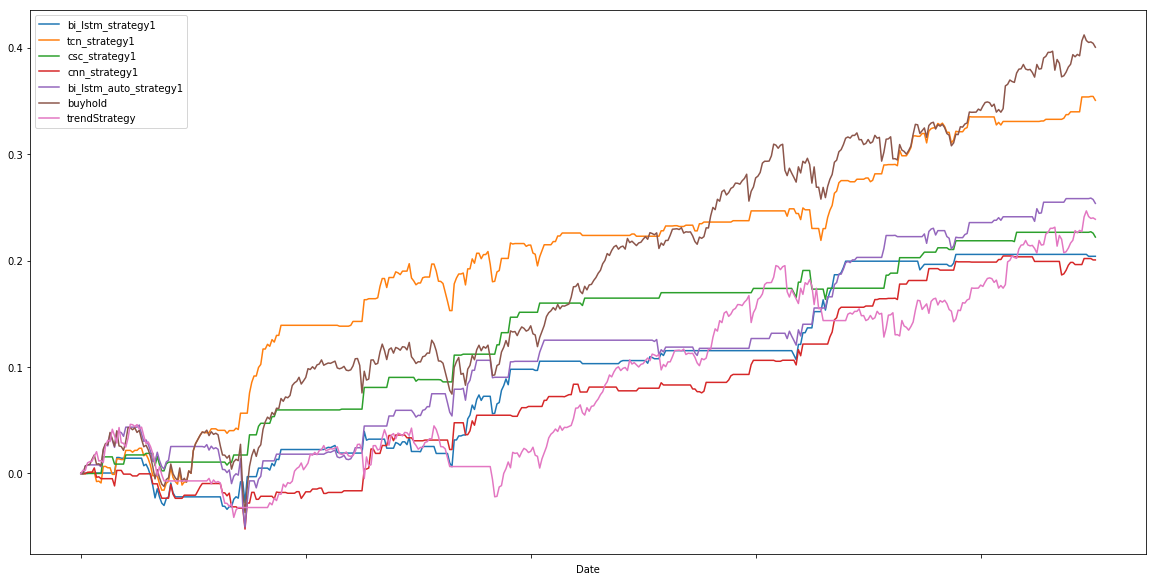

In [98]:
plotstrategies1 = strategies.plot(x="Date", y=["bi_lstm_strategy1", "tcn_strategy1", "csc_strategy1", "cnn_strategy1", "bi_lstm_auto_strategy1", "buyhold", "trendStrategy"], figsize=(20,10))

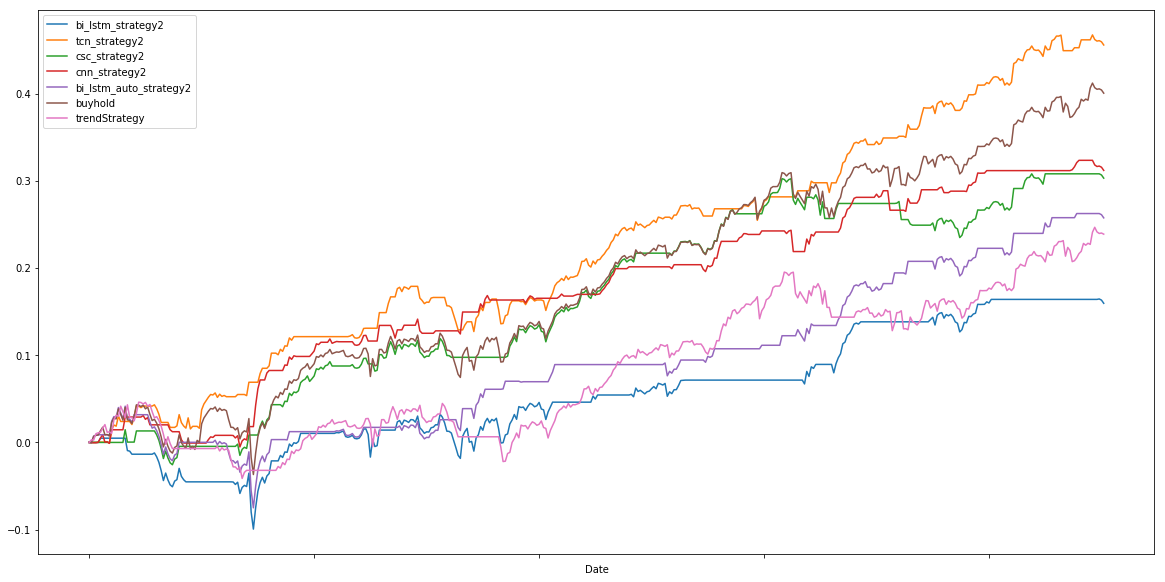

In [99]:
plotstrategies2 = strategies.plot(x="Date", y=["bi_lstm_strategy2", "tcn_strategy2", "csc_strategy2", "cnn_strategy2", "bi_lstm_auto_strategy2", "buyhold", "trendStrategy"], figsize=(20,10))

In [100]:
plotstrategies1.get_figure().savefig("period2_strategy1.png")

In [101]:
plotstrategies2.get_figure().savefig("period2_strategy2.png")

In [102]:
strategies.tail(1)

,Date,buyhold,bi_lstm_strategy1,bi_lstm_strategy2,bi_lstm_auto_strategy1,bi_lstm_auto_strategy2,wavenet_strategy1,wavenet_strategy2,cnn_strategy1,cnn_strategy2,csc_strategy1,csc_strategy2,trendStrategy,tcn_strategy1,tcn_strategy2
4622,12/26/2017,0.400446,0.204009,0.159523,0.253728,0.257464,-0.003663,-0.003663,0.200593,0.311897,0.222086,0.303008,0.238787,0.350554,0.455688
